In [ ]:
# default_exp Runner

# Runner module

> API details.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
from __future__ import print_function
import os
from SEQLinkage.Utils import *
from collections import deque, defaultdict
from os.path import splitext, basename, isdir, isfile
from itertools import chain
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import brewer2mpl
from scipy.optimize import minimize_scalar
import re, glob
from shutil import rmtree as remove_tree
from distutils.file_util import copy_file
#formatters
#the handler, called from main, can call specific formatter.
def format(tpeds, tfam, prev = None, wild_pen = None, muta_pen = None, out_format = 'MERLIN', inherit_mode = None, theta_max = None, theta_inc = None):
    print(env.jobs) #testing line
    if out_format == 'plink':
        parmap(lambda x: format_plink(x, tfam), tpeds, env.jobs)
    elif out_format == 'mega2':
        mkpath(os.path.join(env.outdir, 'MEGA2'))
        parmap(lambda x: format_mega2(x, tfam), tpeds, env.jobs)
    elif out_format == 'merlin':
        mkpath(os.path.join(env.outdir, 'MERLIN'))
        parmap(lambda x: format_merlin(x, tfam), tpeds, env.jobs)
    elif out_format == 'linkage':
        parmap(lambda x: format_linkage(x, tfam, prev, wild_pen, muta_pen, inherit_mode, theta_max, theta_inc), tpeds, env.jobs)

#plink format, ped and map
def format_plink(tped, tfam):
    out_base = '{}/PLINK/{}'.format(env.outdir, splitext(basename(tped))[0])
    with open(tped) as tped_fh, open(tfam) as tfam_fh:
        geno = []
        with open(out_base + '.map', 'w') as m:
            for line in tped_fh:
                s = line.strip().split()
                m.write(env.delimiter.join(s[:3]) + '\n')
                geno.append(deque(s[4:]))
        with open(out_base + '.ped', 'w') as p:
            for line in tfam_fh:
                p.write(line.strip())
                list(map(lambda x: p.write(' {} {}'.format(x.popleft(), x.popleft)), geno))
                p.write("\n")

#mega2 format, datain.01, pedin.01, map.01
def format_mega2(tped, tfam):
    trait = 'A' if env.trait == 'binary' else 'T'
    pedheader = ['Pedigree', 'ID', 'Father', 'Mother', 'Sex', 'Trait.{}'.format(trait)]
    out_base = os.path.join(env.outdir, 'MEGA2')
    suffix =  re.search(r'chr([0-9XY]+)', basename(tped)).groups()[0]
    with open(tped) as tph, open(tfam) as tfh:
        geno = []
        name = []
        with open('{}/map.{}'.format(out_base, suffix), 'w') as m,\
             open('{}/datain.{}'.format(out_base, suffix), 'w') as d:
            d.write('Type\tName\n{}\tTrait\n'.format(trait))
            m.write('Chromosome\tMap.k.a\tName\tMap.k.m\tMap.k.f\thg19.p\n')
            for line in tph:
                s = line.strip().split()
                gene, gno = re.search(r'^(\S+?)(?:\[(\d+)\])?$', s[1]).groups()
                if not gno:
                    gno = '0'
                    with env.format_counter.get_lock():
                        env.format_counter.value += 1
                elif gno == '1':
                    with env.format_counter.get_lock():
                        env.format_counter.value += 1
                if env.format_counter.value % (env.batch * env.jobs) == 0:
                    env.log('{:,d} units processed {{{:.2%}}} ...'.format(env.format_counter.value, float(env.format_counter.value)/env.success_counter.value), flush=True)
                d.write('M\t{}\n'.format(s[1]))
                dis = s[2].split(';')
                dis.insert(1,s[1])
                m.write('{}\t{}\t{}\n'.format(s[0],'\t'.join(dis),s[3]))
                name.append('{0}.M.1\t{0}.M.2'.format(s[1]))
                geno.append(deque(map(lambda x: re.sub(r'^0$', 'NA', x), s[4:])))
        with open('{}/pedin.{}'.format(out_base, suffix), 'w') as p:
            p.write('{}\n'.format('\t'.join(pedheader + name)))
            for line in tfh:
                p.write(line.strip())
                s = line.strip().split()
                list(map(lambda x: p.write('\t{}\t{}'.format(x.popleft(), x.popleft())), geno))
                p.write("\n")

#merlin format
def format_merlin(tped, tfam):
    trait = 'A' if env.trait == 'binary' else 'T'
    #pedheader = ['Pedigree', 'ID', 'Father', 'Mother', 'Sex', 'Trait.{}'.format(trait)]
    out_base = os.path.join(env.outdir, 'MERLIN', splitext(basename(tped))[0])
    #suffix =  re.search(r'chr([0-9XY]+)', basename(tped)).groups()[0]
    with open(tped) as tph, open(tfam) as tfh:
        geno = []
        #name = []
        with open('{}.map'.format(out_base), 'w') as m,\
             open('{}.dat'.format(out_base), 'w') as d:
            d.write('{}\tTrait\n'.format(trait))
            m.write('CHROMOSOME\tMARKER\t\tPOSITION\tFEMALE_POSITION\tMALE_POSITION\n')
            for line in tph:
                s = line.strip().split()
                gene, gno = re.search(r'^(\S+?)(?:\[(\d+)\])?$', s[1]).groups()
                if not gno:
                    gno = '0'
                    with env.format_counter.get_lock():
                        env.format_counter.value += 1
                elif gno == '1':
                    with env.format_counter.get_lock():
                        env.format_counter.value += 1
                if env.format_counter.value % (env.batch * env.jobs) == 0:
                    env.log('{:,d} units processed {{{:.2%}}} ...'.format(env.format_counter.value, float(env.format_counter.value)/env.success_counter.value), flush=True)
                d.write('M\t{}\n'.format(s[1]))
                dis = s[2].split(';')
                dis[1], dis[2] = dis[2], dis[1]
                #dis.insert(1,s[1])
                m.write('{}\t{}\t{}\n'.format(s[0],s[1],'\t'.join(dis)))
                #name.append('{0}.M.1\t{0}.M.2'.format(s[1]))
                geno.append(deque(s[4:]))
        with open('{}.ped'.format(out_base), 'w') as p:
            #p.write('{}\n'.format('\t'.join(pedheader + name)))
            for line in tfh:
                p.write(line.strip())
                s = line.strip().split()
                list(map(lambda x: p.write('\t{}\t{}'.format(x.popleft(), x.popleft())), geno))
                p.write("\n")


#linkage format, .pre and .loc
#per locus, per family based
#because the haplotype patterns are different from family to family.
#You can analyze them all together
def format_linkage(tped, tfam, prev, wild_pen, muta_pen, inherit_mode, theta_max, theta_inc):
    out_base = '{}/LINKAGE/{}'.format(env.tmp_dir, splitext(basename(tped))[0])
    with open(tped) as tped_fh, open(tfam) as tfam_fh:
        fams = parse_tfam(tfam_fh)
        #parse per family per locus AF file
        af = defaultdict(lambda: [])
        #try to open the file for allele frequencies, otherwise use the default value
        try:
            with open(os.path.join(env.tmp_cache, basename(out_base) + '.freq')) as af_fh:
                for line in af_fh:
                    s = line.strip().split()
                    freq = list(map(lambda x: max(1e-3, float(x)), s[2:]))
                    relativefreq = np.array(freq)/sum(freq)
                    af[(s[0],s[1])] = list(map(str, relativefreq))
        except IOError:
            env.error('freq info not properly read for [{}]'.format(basename(out_base)))
        #parse tped
        heter_pen = wild_pen
        if inherit_mode == 'AD':
            heter_pen = muta_pen
        for line in tped_fh:
            s = line.strip().split()
            gene, gno = re.search(r'^(\S+?)(?:\[(\d+)\])?$', s[1]).groups()
            if not gno:
                gno = '0'
                with env.format_counter.get_lock():
                    env.format_counter.value += 1
            elif gno == '1':
                with env.format_counter.get_lock():
                    env.format_counter.value += 1
            if env.format_counter.value % (env.batch * env.jobs) == 0:
                env.log('{:,d} units processed {{{:.2%}}} ...'.format(env.format_counter.value, float(env.format_counter.value)/env.success_counter.value), flush=True)
            for fid in fams:
                workdir = '{}/{}/{}'.format(out_base, gene, fid)
                with env.lock:
                    mkpath(workdir)
                #env.error("fid {} num {}\n".format(fid, fams[fid].get_member_ids()))
                fam_af = af[(fid, s[1])]
                if not fam_af:
                    #env.log('All missing in this family {} on {}[{}], skipped ...'.format(fid, gene, gno), flush=True)
                    with env.skipped_counter.get_lock():
                        env.skipped_counter.value += 1
                    removeEmptyDir(workdir)
                    continue
                ids = fams[fid].get_sorted_ids()
                idxes = list(map(lambda x: fams[fid].get_member_idx(x), ids))
                gs = list(map(lambda x: s[2 * x + 4 : 2 * x + 6], idxes))
                gs_num = len(set(filter(lambda x: x != '0', chain(*gs))))
                if gs_num >= 10:
                    with env.skipped_counter.get_lock():
                        env.skipped_counter.value += 1
                    removeEmptyDir(workdir)
                    continue
                with env.lock:
                    mkpath(workdir)
                with open('{}/{}.PRE'.format(workdir, gno), 'w') as pre:
                    pre.write(''.join("{} {} {} {}\n".format(fid, fams[fid].print_member(pid), s[2*fams[fid].get_member_idx(pid) + 4], s[2*fams[fid].get_member_idx(pid) + 5]) for pid in ids))
                with open('{}/{}.LOC'.format(workdir, gno), 'w') as loc:
                    loc.write("2 0 0 5\n")
                    loc.write("0 0.0 0.0 0\n")
                    loc.write("1 2\n")
                    loc.write("1 2\n")
                    loc.write(" {} {}\n".format(1 - prev, prev))
                    loc.write(" 1\n")
                    loc.write(" {} {} {}\n".format(wild_pen, heter_pen, muta_pen))
                    loc.write("3 {}\n".format(gs_num))
                    loc.write(' ' + ' '.join(fam_af) + "\n")
                    loc.write("0 0\n")
                    loc.write("0.0\n")
                    loc.write("1 {} {}\n".format(theta_inc, theta_max))

            removeEmptyDir('{}/{}'.format(out_base, gene))
    tped_fh.close()
    tfam_fh.close()
    removeEmptyDir('{}'.format(out_base))

#parse tfam file, store families into the Pedigree class
def parse_tfam(fh):
    fams = defaultdict(lambda: Pedigree())
    idx = 0
    for line in fh:
        s = line.strip().split()
        fams[s[0]].add_member(s[1:], idx)
        idx += 1
    return fams

#This is to sort the members of a pedigree.
#To make sure that parents come before offsprings.
class Pedigree:
    def __init__(self):
        self.fid = None
        self.data = {}
        self.graph = defaultdict(lambda:[]) #, defaultdict(lambda:[])]
        self.sorted = []

    def add_member(self, info, idx): #list [pid, father, mother, sex, pheno]
        if info[1] != '0' and info[2] != '0':
            self.graph[info[1]].append(info[0])
            self.graph[info[2]].append(info[0])
        self.data[info[0]] = info + [idx]

    def get_member_info(self, pid):
        return self.data[pid][:-1]

    def get_member_idx(self, pid):
        return self.data[pid][-1]

    def get_member_ids(self):
        return self.data.keys()

    def print_member(self, pid):
        return ' '.join(self.get_member_info(pid))

    def get_sorted_ids(self):
        if self.sorted:
            return self.sorted
        else:
            #This algorithm was first described by Kahn (1962)
            S_no_parents = list(filter(lambda x: True if self.get_member_info(x)[1] == '0' else False, self.get_member_ids()))
            graph = self.graph.copy()
            while(S_no_parents):
                n = S_no_parents.pop()
                self.sorted.append(n)
                if n not in graph:
                    continue
                offsprings = graph.pop(n)
                for m in offsprings:
                    father = self.get_member_info(m)[1]
                    mother = self.get_member_info(m)[2]
                    if father not in graph and mother not in graph:
                        S_no_parents.append(m)
            if graph:
                raise Exception("There is a loop in the pedigree: {}\n".format(' '.join(graph.keys())))
            else:
                return self.sorted

#runners
def run_linkage(blueprint, theta_inc, theta_max, to_plot = True):
    try:
        remove_tree(os.path.join(env.outdir, 'heatmap'))
    except OSError:
        pass
    with open(os.path.join(env.tmp_dir, 'LinkageRuntimeError.txt'), 'w') as runtime_err:
        workdirs = glob.glob('{}/LINKAGE/{}.chr*'.format(env.tmp_dir, env.output))
        parmap(lambda x: linkage_worker(blueprint, x, theta_inc, theta_max, runtime_err, to_plot) , workdirs, env.jobs)

def linkage_worker(blueprint, workdir, theta_inc, theta_max, errfile, to_plot = True):
    #env.log("Start running LINKAGE for {} ...".format(workdir), flush=True)
    #hash genes into genemap
    genemap = {}
    if blueprint:
        with open(blueprint) as f:
            for line in f.readlines():
                chrID, start, end, gene = line.strip().split()[:4]
                genemap[gene] = [chrID, int(start), int(end)]
    else:
        tped = os.path.join(env.tmp_cache, basename(workdir) + '.tped')
        with open(tped) as f:
            for line in f.readlines():
                items = line.strip().split()[:4]
                chrID = items[0]
                gene = items[1]
                pos = items[3]
                genemap[gene] = [chrID, int(pos), int(pos)+1]
    with env.lock:
        mkpath('{}/heatmap'.format(env.outdir))
    lods_fh = open('{}/heatmap/{}.lods'.format(env.outdir, basename(workdir)), 'w')
    hlods_fh = open('{}/heatmap/{}.hlods'.format(env.outdir, basename(workdir)), 'w')
    famlods_fh = open('{}/heatmap/{}.family-lods'.format(env.outdir, basename(workdir)), 'w')
    genes = list(filter(lambda g: g in genemap, map(basename, glob.glob(workdir + '/*'))))
    for gene in sorted(genes, key=lambda g: genemap[g]):
        lods = {}
        hlods = {}
        fams = map(basename, filter(isdir, glob.glob('{}/{}/*'.format(workdir, gene))))
        for fam in fams:
            with cd('{}/{}/{}'.format(workdir, gene, fam)):
                units = map(lambda x: re.sub(r'^(\d+?)\.PRE$', r'\1', x) ,glob.glob('*.PRE'))
                for unit in units:
                    copy_file('{}.LOC'.format(unit), 'datafile.dat')
                    copy_file('{}.PRE'.format(unit), 'pedfile.pre')

                    step1 = runCommand(['makeped', 'pedfile.pre', 'pedfile.ped', 'n'],
                                       show_stderr = False, return_zero = False)
                    if step1[1]:
                        if env.debug:
                            with env.lock:
                                print("makeped error:", step1[1], file = sys.stderr)
                        with env.makeped_counter.get_lock():
                            env.makeped_counter.value += 1
                        with env.lock:
                            errfile.write(step1[1])
                        continue
                    step2 = runCommand(['pedcheck', '-p', 'pedfile.ped', '-d', 'datafile.dat', '-c'],
                                       show_stderr = False, return_zero = False)
                    if step2[1]:
                        lines = [x for x in step2[1].split('\n')
                                 if not x.strip().startswith('*') and x.strip()]
                        if len(lines) > 0:
                            env.log('{} lines'.format(len(lines)))
                            with env.lock:
                                errfile.write(step2[1])
                            if env.debug:
                                with env.lock:
                                    print("pedcheck error:", '\n'.join(lines), file = sys.stderr)
                    try:
                        copy_file('zeroout.dat', 'pedfile.dat')
                    except:
                        with env.pedcheck_counter.get_lock():
                            env.pedcheck_counter.value += 1
                        continue
                    step3 = runCommand('unknown', show_stderr = False, return_zero = False)
                    if step3[1]:
                        if env.debug:
                            with env.lock:
                                print("unkn error:", step3[1], file = sys.stderr)
                        with env.unknown_counter.get_lock():
                            env.unknown_counter.value += 1
                        with env.lock:
                            errfile.write(step3[1])
                        continue
                    step4 = runCommand('mlink', show_stderr = False, return_zero = False)
                    if step4[1]:
                        if env.debug:
                            with env.lock:
                                print("mlink error:", step4[1], file = sys.stderr)
                        with env.lock:
                            errfile.write(step4[1])
                    try:
                        copy_file('outfile.dat', '{}.out'.format(unit))
                    except:
                        with env.mlink_counter.get_lock():
                            env.mlink_counter.value += 1
                        continue
                    #clean linkage tmp files
                    for f in set(glob.glob('*.dat') + glob.glob('ped*') + ['names.tmp']):
                        os.remove(f)
                    #collect lod scores of different thelta for the fam
                    with open('{}.out'.format(unit)) as out:
                        raw = out.read()
                        for i in re.finditer(r'^THETAS\s+(0\.\d+)(?:\n.+?){7}LOD SCORE =\s+(-?\d+\.\d+)', raw, re.MULTILINE):
                            theta, lod = map(float, i.group(1,2))
                            #if float(lod) < 1e-6:
                            #    lod = 0
                            if theta not in lods:
                                lods[theta] = {fam: lod}
                            elif fam not in lods[theta] or lod > lods[theta][fam]:
                                lods[theta][fam] = lod
        for theta in sorted(lods.keys()):
            lods_fh.write('{} {} {} {}\n'.format(gene, ' '.join(map(str, genemap[gene])), theta, sum(lods[theta].values())))
            for fam in lods[theta]:
                famlods_fh.write('{} {} {} {} {}\n'.format(fam, gene, ' '.join(map(str, genemap[gene])), theta, lods[theta][fam]))
            res = minimize_scalar(hlod_fun(lods[theta].values(), -1), bounds=(0,1), method='bounded', options={'xatol':1e-8})
            a = res.x
            hlods_fh.write('{} {} {} {} {}\n'.format(gene, ' '.join(map(str, genemap[gene])), a, theta, hlod_fun(lods[theta].values())(a)))
        with env.run_counter.get_lock():
            env.run_counter.value += 1
        if env.run_counter.value % (env.batch * env.jobs) == 0:
            env.log('Linkage analysis for {:,d} units completed {{{:.2%}}} ...'.format(env.run_counter.value, float(env.run_counter.value)/env.success_counter.value), flush=True)
    lods_fh.close()
    hlods_fh.close()
    famlods_fh.close()
    if to_plot:
        heatmap('{}/heatmap/{}.lods'.format(env.outdir, basename(workdir)), theta_inc, theta_max)
        heatmap('{}/heatmap/{}.hlods'.format(env.outdir, basename(workdir)), theta_inc, theta_max)
    #env.log("Finished running LINKAGE for {}.".format(workdir), flush=True)


def hinton(filename, max_weight=None, ax=None):
    if ax is None:
        ax = plt.gca()
    matrix = np.random.rand(20, 20) - 0.5
    if not max_weight:
        max_weight = 2**np.ceil(np.log(np.abs(matrix).max())/np.log(2))
    ax.patch.set_facecolor('gray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    chrID = re.search(r'\.chr([0-9XY]+)\.', filename).group(1)
    ax.set_title('Chromosome {}'.format(chrID))
    for (x,y),w in np.ndenumerate(matrix):
        color = 'white' if w > 0 else 'black'
        size = np.sqrt(np.abs(w))
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)
    ax.autoscale_view()
    ax.invert_yaxis()
    plt.savefig(filename)


def heatmap(file, theta_inc, theta_max):
    #env.log("Start ploting heatmap for {} ...".format(file), flush=True)
    if os.path.getsize(file) == 0:
        hinton('{}.png'.format(file))
        return
    lods = []
    with open(file, 'r') as f:
        for line in f.readlines():
            theta,lod = line.split()[-2:]
            if float(theta) >= theta_max:
                continue
            lods.append(lod)
        if max(lods) == min(lods):
            #env.log('Max equals Min for [{}], No real heatmap will be generated.'.format(file))
            hinton('{}.png'.format(file))
            #return
        Num=int(round(theta_max/theta_inc))
        lods = np.array(list(map(float,lods))).reshape((-1,Num))
        chrID = re.search(r'\.chr([0-9XY]+)\.', file).group(1)
        fig, ax = plt.subplots(1)
        ax.set_title('Chromosome {}'.format(chrID))
        ax.pcolormesh(lods.transpose(),cmap=brewer2mpl.get_map('Blues', 'Sequential', 9).mpl_colormap)
        fig.savefig('{}.png'.format(file))
        #fig.close()
    #env.log("Finished ploting heatmap for {}.".format(file), flush=True)

def hlod_fun(Li, sign=1):
    def _fun(alpha):
        return sign * sum(np.log10(alpha*np.power(10, list(Li)) + 1 - alpha))
    return _fun

def html(theta_inc, theta_max, limit):
    if limit <= 0:
        return
    head = """<html>
    <head>
    <title>Results for {}</title>""".format(env.output) + """
    <style>
    table {
	font-family: verdana,arial,sans-serif;
	font-size:12px;
	color:#333333;
	border-width: 1px;
	border-color: #CCCCCC;
	border-collapse: collapse;
    }
    table th {
	border-width: 1px;
	padding: 6px;
	color: #006295;
	border-style: solid;
	border-color: #CCCCCC;
	background-color: #F8F8F8;
    }
    table td {
	border-width: 1px;
	padding: 6px;
	border-style: solid;
	border-color: #CCCCCC;
	background-color: #ffffff;
    }
    a,
    a:link,
    a:visited,
    a:active
    {
	color: #3366CC;
	border-bottom: 1px dotted #3366CC;
	text-decoration:none;
    }
    a:hover
    {
	border-bottom: none;
	color: #ffffff;
    background-color: #006295;
    }
    body {font-family:Lucida Sans Unicode,arial,sans-serif;}
    </style>
    <script type="text/javascript">
    function toggle(obj) {
    var elstyle = document.getElementById(obj).style;
    var text    = document.getElementById(obj + "tog");
    if (elstyle.display == \'none\') {
    elstyle.display = \'block\';
    text.innerHTML = "hide";
    } else {
    elstyle.display = \'none\';
    text.innerHTML = "show";
    }
    }</script>
    </head>"""
    body = """<body>
    <p><a href="#Lods_Table" onclick="toggle(\'lods_tbl\')">Ranked LOD scores</a>
    <div id="lods_tbl" class="divinfo", style="border:0px;width:auto;height:auto;overflow-y:hidden;overflow-x:scroll;">{}</div></p>
    <p><a href="#Hlods_Table" onclick="toggle(\'hlods_tbl\')">Ranked HLOD scores</a>
    <div id="hlods_tbl" class="divinfo", style="border:0px;width:auto;height:auto;overflow-y:hidden;overflow-x:scroll;">{}</div></p>
    <p><a href="#Lods_Heatmap" onclick="toggle(\'lods_heatmap\')">LOD scores heatmap</a>
    <div id="lods_heatmap">{}</div></p>
    <p><a href="#Hlods_Heatmap" onclick="toggle(\'hlods_heatmap\')">HLOD scores heatmap</a>
    <div id="hlods_heatmap">{}</div></p>
    </body>
    </html>"""
    env.log('Generating Report in HTML format ...', flush = True)
    with open('{}/{}_Report.html'.format(env.outdir, env.output), 'w') as f:
        #t = Template(index)
        #c = Context({ "lods": lods_tbl })
        f.write(head + body.format(html_table('Lod', theta_inc, theta_max, limit), html_table('Hlod', theta_inc, theta_max, limit), html_img('lod'), html_img('hlod')))
    env.log('Report for [{}] is generated in HTML format\n'.format(env.output), flush = True)

def html_img(ltype):
    chrs = ['{}'.format(i+1) for i in range(22)] + ['X', 'Y']
    imgs = ['heatmap/{0}.chr{1}.{2}s.png'.format(env.output, chrID, ltype) for chrID in chrs]
    exist_imgs = [img for img in imgs if isfile('{}/{}'.format(env.outdir,img))]
    return ''.join('<img src={}></img>'.format(img) for img in exist_imgs)

def html_table(type, theta_inc, theta_max, limit):
    colNum = int(round(theta_max/theta_inc))
    theta_orders = range(colNum)
    thetas = map(lambda x: theta_inc * x, range(colNum))
    #table
    table = r'<table style="width:300px;font-size:12px">{}</table>'
    #table header
    lods_header = r'<tr>{}</tr>'.format(''.join(r'<th colspan="2">&#952;={}</td>'.format(x) for x in thetas))
    lods_header += r'<tr>{}</tr>'.format(r'<th rowspan="2">{}</th><th>Marker name</th>'.format(type) * colNum)
    lods_header += r'<tr>{}</tr>'.format(r'<th>chr:start-end</th>' * colNum)
    #initialize lods dict
    lods = {}
    for theta_order in theta_orders:
        lods[theta_order] = {}
        #print '{}\n'.format(theta_order)
    #read lods
    lods_files = glob.glob('{}/heatmap/{}.*.{}s'.format(env.outdir, env.output, type.lower()))
    for file in lods_files:
        with open(file, 'r') as f:
            for line in f:
                if type == 'Lod':
                    gene, chrId, start, end, theta, lod = line.strip().split()
                    if int(round(float(theta)/theta_inc)) >= colNum:
                        continue
                    lods[int(round(float(theta)/theta_inc))][gene] = ['<b>{}</b>'.format(round(float(lod),3)), gene, chrId, start, end]
                elif type == 'Hlod':
                    gene, chrId, start, end, a, theta, lod = line.strip().split()
                    if int(round(float(theta)/theta_inc)) >= colNum:
                        continue
                    lods[int(round(float(theta)/theta_inc))][gene] = ['<b>{}</b><br>&#945;={}'.format(round(float(lod),3), round(float(a),3)), gene, chrId, start, end]
                else:
                    env.error('Wrong type of LOD')

    #collect result
    res = np.empty((len(theta_orders), limit), dtype=list)
    for theta_order in theta_orders:
        i=0
        for gene in sorted(lods[theta_order].keys(), key=lambda x: lods[theta_order][x][0], reverse=True):
            if i >= limit:
                break
            res[theta_order][i] = lods[theta_order][gene]
            i += 1
    #print res
    #write lods table
    lods_res = ''
    for i in range(min(limit, len(lods[0].keys()))):
        lods_res += r'<tr>{}</tr>'.format(''.join(r'<td rowspan="2">{}</td><td>{}</td>'.format(res[theta_order][i][0],res[theta_order][i][1]) for theta_order in theta_orders))
        lods_res += r'<tr>{}</tr>'.format(''.join(r'<td>{}:{}-{}</td>'.format(res[theta_order][i][2],res[theta_order][i][3],res[theta_order][i][4]) for theta_order in theta_orders))
    lods_tbl = table.format(lods_header + lods_res)
    return lods_tbl



## Testing runner

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

### 1. parameters

In [ ]:
from SEQLinkage.Main import *
from __future__ import print_function
from SEQLinkage.Utils import *
from multiprocessing import Process, Queue
from collections import OrderedDict
import itertools
from copy import deepcopy
import sys, faulthandler, platform
import numpy as np
import os
if sys.version_info.major == 2:
    from cstatgen import cstatgen_py2 as cstatgen
    from cstatgen.egglib import Align
else:
    from cstatgen import cstatgen_py3 as cstatgen
    import egglib
    from egglib import Align

In [ ]:
args = Args().parser.parse_args('--fam data/mwe_normal_fam.csv --vcf data/first1000snp_full_samples.vcf.gz -f MERLIN --blueprint data/genemap.hg38.txt --freq AF --run-linkage -K 0.001 --moi AD -W 0 -M 1 --theta-max 0.5 --theta-inc 0.05'.split())

In [ ]:
args

Namespace(bin=0.8, blueprint='data/genemap.hg38.txt', single_markers=False, tfam='data/mwe_normal_fam.csv', vcf='data/first1000snp_full_samples.vcf.gz', build='hg19', prephased=False, freq='AF', freq_by_fam=None, mle=False, rvhaplo=False, recomb_max=1, recomb_cross_fam=False, rsq=0.0, include_vars=None, maf_cutoff=1.0, chr_prefix=None, output=None, format=['MERLIN'], prevalence=0.001, inherit_mode='AD', wild_pen=0.0, muta_pen=1.0, theta_max=0.5, theta_inc=0.05, run_linkage=True, output_limit=10, jobs=16, tempdir=None, vanilla=True, quiet=False, debug=False, no_save=False, func=<function main at 0x2b7a3363e1f0>)

In [ ]:
checkParams(args)

MESSAGE: Binary trait detected in [/mnt/mfs/statgen/yin/Github/linkage/SEQpy3/data/mwe_normal_fam.csv]


True

In [ ]:
if args.no_save:
    cache = NoCache()
else:
    cache = Cache(env.cache_dir, env.output, vars(args))
cache.setID('vcf')

## 2. Testing run_linkage

In [ ]:
args.run_linkage

True

In [ ]:
cache.setID('analysis')

In [ ]:
env.output

'LINKAGE'

In [ ]:
?cache.load

Signature: cache.load(target_dir=None, names=None)
Docstring: <no docstring>
File:      /mnt/mfs/statgen/yin/Github/linkage/SEQpy3/SEQLinkage/Utils.py
Type:      method


In [ ]:
cache.cache_name

'/mnt/mfs/statgen/yin/Github/linkage/SEQpy3/cache/LINKAGE.cache'

In [ ]:
not args.vanilla and cache.check()

False

In [ ]:
fmt = args.format[0]

In [ ]:
args.blueprint

'data/genemap.hg38.txt'

In [ ]:
args.theta_inc

0.05

In [ ]:
args.theta_max

0.5

In [ ]:
args.output_limit

10

In [ ]:
??run_linkage

Signature: run_linkage(blueprint, theta_inc, theta_max, to_plot=True)
Docstring: <no docstring>
Source:   
def run_linkage(blueprint, theta_inc, theta_max, to_plot = True):
    try:
        remove_tree(os.path.join(env.outdir, 'heatmap'))
    except OSError:
        pass
    with open(os.path.join(env.tmp_dir, 'LinkageRuntimeError.txt'), 'w') as runtime_err:
        workdirs = glob.glob('{}/LINKAGE/{}.chr*'.format(env.tmp_dir, env.output))
        parmap(lambda x: linkage_worker(blueprint, x, theta_inc, theta_max, runtime_err, to_plot) , workdirs, env.jobs)
File:      /tmp/2206534.1.plot.q/ipykernel_30528/2972776299.py
Type:      function


In [ ]:
LINKAGE/LINKAGE$ head LINKAGE.chr1/DDX11L1/1036/*

In [ ]:
env.tmp_dir = './LINKAGE'

In [ ]:
env.jobs=8

In [ ]:
blueprint, theta_inc, theta_max, to_plot = args.blueprint, args.theta_inc, args.theta_max, True

In [ ]:
--fam data/mwe_normal_fam.csv --vcf data/first1000snp_full_samples.vcf.gz -f LINKAGE --blueprint data/genemap.hg38.txt --freq AF

In [ ]:
env.tmp_dir

'./LINKAGE'

In [ ]:
env.output

'LINKAGE'

['./LINKAGE/LINKAGE/LINKAGE.chr1']


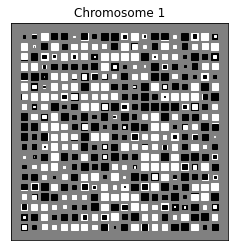

In [ ]:
with open(os.path.join(env.tmp_dir, 'LinkageRuntimeError.txt'), 'w') as runtime_err:
    workdirs = glob.glob('{}/LINKAGE/{}.chr*'.format(env.tmp_dir, env.output))
    print(workdirs)
    linkage_worker(blueprint, workdirs[0], theta_inc, theta_max, runtime_err, to_plot)

In [ ]:
tmp = {'a':1,'b':2}

In [ ]:
tmp.values()

dict_values([1, 2])

In [ ]:
def run_linkage(blueprint, theta_inc, theta_max, to_plot = True):
    try:
        remove_tree(os.path.join(env.outdir, 'heatmap'))
    except OSError:
        pass
    with open(os.path.join(env.tmp_dir, 'LinkageRuntimeError.txt'), 'w') as runtime_err:
        workdirs = glob.glob('{}/LINKAGE/{}.chr*'.format(env.tmp_dir, env.output))
        parmap(lambda x: linkage_worker(blueprint, x, theta_inc, theta_max, runtime_err, to_plot) , workdirs, env.jobs)

def linkage_worker(blueprint, workdir, theta_inc, theta_max, errfile, to_plot = True):
    #env.log("Start running LINKAGE for {} ...".format(workdir), flush=True)
    #hash genes into genemap
    genemap = {}
    if blueprint:
        with open(blueprint) as f:
            for line in f.readlines():
                chrID, start, end, gene = line.strip().split()[:4]
                genemap[gene] = [chrID, int(start), int(end)]
    else:
        tped = os.path.join(env.tmp_cache, basename(workdir) + '.tped')
        with open(tped) as f:
            for line in f.readlines():
                items = line.strip().split()[:4]
                chrID = items[0]
                gene = items[1]
                pos = items[3]
                genemap[gene] = [chrID, int(pos), int(pos)+1]
    with env.lock:
        mkpath('{}/heatmap'.format(env.outdir))
    lods_fh = open('{}/heatmap/{}.lods'.format(env.outdir, basename(workdir)), 'w')
    hlods_fh = open('{}/heatmap/{}.hlods'.format(env.outdir, basename(workdir)), 'w')
    famlods_fh = open('{}/heatmap/{}.family-lods'.format(env.outdir, basename(workdir)), 'w')
    genes = list(filter(lambda g: g in genemap, map(basename, glob.glob(workdir + '/*'))))
    for gene in sorted(genes, key=lambda g: genemap[g]):
        lods = {}
        hlods = {}
        fams = map(basename, filter(isdir, glob.glob('{}/{}/*'.format(workdir, gene))))
        for fam in fams:
            with cd('{}/{}/{}'.format(workdir, gene, fam)):
                units = map(lambda x: re.sub(r'^(\d+?)\.PRE$', r'\1', x) ,glob.glob('*.PRE'))
                for unit in units:
                    copy_file('{}.LOC'.format(unit), 'datafile.dat')
                    copy_file('{}.PRE'.format(unit), 'pedfile.pre')

                    step1 = runCommand(['makeped', 'pedfile.pre', 'pedfile.ped', 'n'],
                                       show_stderr = False, return_zero = False)
                    if step1[1]:
                        if env.debug:
                            with env.lock:
                                print("makeped error:", step1[1], file = sys.stderr)
                        with env.makeped_counter.get_lock():
                            env.makeped_counter.value += 1
                        with env.lock:
                            errfile.write(step1[1])
                        continue
                    step2 = runCommand(['pedcheck', '-p', 'pedfile.ped', '-d', 'datafile.dat', '-c'],
                                       show_stderr = False, return_zero = False)
                    if step2[1]:
                        lines = [x for x in step2[1].split('\n')
                                 if not x.strip().startswith('*') and x.strip()]
                        if len(lines) > 0:
                            env.log('{} lines'.format(len(lines)))
                            with env.lock:
                                errfile.write(step2[1])
                            if env.debug:
                                with env.lock:
                                    print("pedcheck error:", '\n'.join(lines), file = sys.stderr)
                    try:
                        copy_file('zeroout.dat', 'pedfile.dat')
                    except:
                        with env.pedcheck_counter.get_lock():
                            env.pedcheck_counter.value += 1
                        continue
                    step3 = runCommand('unknown', show_stderr = False, return_zero = False)
                    if step3[1]:
                        if env.debug:
                            with env.lock:
                                print("unkn error:", step3[1], file = sys.stderr)
                        with env.unknown_counter.get_lock():
                            env.unknown_counter.value += 1
                        with env.lock:
                            errfile.write(step3[1])
                        continue
                    step4 = runCommand('mlink', show_stderr = False, return_zero = False)
                    if step4[1]:
                        if env.debug:
                            with env.lock:
                                print("mlink error:", step4[1], file = sys.stderr)
                        with env.lock:
                            errfile.write(step4[1])
                    try:
                        copy_file('outfile.dat', '{}.out'.format(unit))
                    except:
                        with env.mlink_counter.get_lock():
                            env.mlink_counter.value += 1
                        continue
                    #clean linkage tmp files
                    for f in set(glob.glob('*.dat') + glob.glob('ped*') + ['names.tmp']):
                        os.remove(f)
                    #collect lod scores of different thelta for the fam
                    with open('{}.out'.format(unit)) as out:
                        raw = out.read()
                        for i in re.finditer(r'^THETAS\s+(0\.\d+)(?:\n.+?){7}LOD SCORE =\s+(-?\d+\.\d+)', raw, re.MULTILINE):
                            theta, lod = map(float, i.group(1,2))
                            #if float(lod) < 1e-6:
                            #    lod = 0
                            if theta not in lods:
                                lods[theta] = {fam: lod}
                            elif fam not in lods[theta] or lod > lods[theta][fam]:
                                lods[theta][fam] = lod
        for theta in sorted(lods.keys()):
            lods_fh.write('{} {} {} {}\n'.format(gene, ' '.join(map(str, genemap[gene])), theta, sum(lods[theta].values())))
            for fam in lods[theta]:
                famlods_fh.write('{} {} {} {} {}\n'.format(fam, gene, ' '.join(map(str, genemap[gene])), theta, lods[theta][fam]))
            print(lods[theta].values())
            res = minimize_scalar(hlod_fun(lods[theta].values(), -1), bounds=(0,1), method='bounded', options={'xatol':1e-8})
            a = res.x
            hlods_fh.write('{} {} {} {} {}\n'.format(gene, ' '.join(map(str, genemap[gene])), a, theta, hlod_fun(lods[theta].values())(a)))
        with env.run_counter.get_lock():
            env.run_counter.value += 1
        if env.run_counter.value % (env.batch * env.jobs) == 0:
            env.log('Linkage analysis for {:,d} units completed {{{:.2%}}} ...'.format(env.run_counter.value, float(env.run_counter.value)/env.success_counter.value), flush=True)
    lods_fh.close()
    hlods_fh.close()
    famlods_fh.close()
    if to_plot:
        heatmap('{}/heatmap/{}.lods'.format(env.outdir, basename(workdir)), theta_inc, theta_max)
        heatmap('{}/heatmap/{}.hlods'.format(env.outdir, basename(workdir)), theta_inc, theta_max)
    #env.log("Finished running LINKAGE for {}.".format(workdir), flush=True)




In [ ]:
run_linkage(args.blueprint, args.theta_inc, args.theta_max, args.output_limit)

In [ ]:
import sys, os, subprocess, shutil, glob, shlex, re, hashlib, tempfile
try:
    from cStringIO import StringIO ## for Python 2
    import urlparse
except ImportError:
    from io import StringIO ## for Python 3
    from urllib import parse as urlparse
from contextlib import contextmanager
from multiprocessing import Pool, Process, Queue, Lock, Value, cpu_count
import itertools
from collections import OrderedDict, defaultdict, Counter
from shutil import rmtree as remove_tree
from zipfile import ZipFile

In [ ]:
cpu_count()

32

In [ ]:
def parmap(f, X, nprocs = cpu_count()):
    def spawn(f):
        def fun(q_in,q_out):
            while True:
                i,x = q_in.get()
                if i is None:
                    break
                q_out.put((i,f(x)))
        return fun
    #
    q_in   = Queue(1)
    q_out  = Queue()
    proc = [Process(target=spawn(f),args=(q_in,q_out)) for _ in range(nprocs)]
    for p in proc:
        p.daemon = True
        p.start()
    sent = [q_in.put((i,x)) for i,x in enumerate(X)]
    [q_in.put((None,None)) for _ in range(nprocs)]
    res = [q_out.get() for _ in range(len(sent))]
    [p.join() for p in proc]
    return [x for i,x in sorted(res)]

In [ ]:
if args.run_linkage:
    cache.setID('analysis')
    if not args.vanilla and cache.check():
        env.log('Loading linkage analysis result from archive ...'.format(fmt.upper()))
        cache.load(target_dir = env.output, names = ['heatmap'])
    else:
        env.log('Running linkage analysis ...'.format(fmt.upper()))
        run_linkage(args.blueprint, args.theta_inc, args.theta_max, args.output_limit)
        env.log('Linkage analysis succesfully performed for {:,d} units\n'.\
                format(env.run_counter.value, fmt.upper()), flush = True)
        if env.makeped_counter.value:
            env.log('{} "makeped" runtime errors occurred'.format(env.makeped_counter.value))
        if env.pedcheck_counter.value:
            env.log('{} "pedcheck" runtime errors occurred'.format(env.pedcheck_counter.value))
        if env.unknown_counter.value:
            env.log('{} "unknown" runtime errors occurred'.format(env.unknown_counter.value))
        if env.mlink_counter.value:
            env.log('{} "mlink" runtime errors occurred'.format(env.mlink_counter.value))
        cache.write(arcroot = 'heatmap', source_dir = os.path.join(env.output, 'heatmap'), mode = 'a')
    html(args.theta_inc, args.theta_max, args.output_limit)
else:
    env.log('Saving data to [{}]'.format(os.path.abspath(env.output)))
    cache.load(target_dir = env.output, names = [fmt.upper() for fmt in args.format])

MESSAGE: Running linkage analysis ...
MESSAGE: Linkage analysis succesfully performed for 1 units
MESSAGE: 2 "pedcheck" runtime errors occurred
MESSAGE: Report for [tsq20211129] is generated in HTML format


In [ ]:
    env.log('Saving data to [{}]'.format(os.path.abspath(env.output)))
    cache.load(target_dir = env.output, names = [fmt.upper() for fmt in args.format])

MESSAGE: Saving data to [/mnt/mfs/statgen/yin/Github/linkage/SEQpy2/testseqlink]


### 3.Testing heatmap

In [ ]:
def hinton(filename, max_weight=None, ax=None):
    if ax is None:
        ax = plt.gca()
    matrix = np.random.rand(20, 20) - 0.5
    if not max_weight:
        max_weight = 2**np.ceil(np.log(np.abs(matrix).max())/np.log(2))
    ax.patch.set_facecolor('gray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    chrID = re.search(r'\.chr([0-9XY]+)\.', filename).group(1)
    ax.set_title('Chromosome {}'.format(chrID))
    for (x,y),w in np.ndenumerate(matrix):
        color = 'white' if w > 0 else 'black'
        size = np.sqrt(np.abs(w))
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)
    ax.autoscale_view()
    ax.invert_yaxis()
    plt.savefig(filename)


def heatmap(file, theta_inc, theta_max):
    #env.log("Start ploting heatmap for {} ...".format(file), flush=True)
    if os.path.getsize(file) == 0:
        hinton('{}.png'.format(file))
        return
    lods = []
    with open(file, 'r') as f:
        for line in f.readlines():
            theta,lod = line.split()[-2:]
            if float(theta) >= theta_max:
                print(line)
                continue
            lods.append(lod)
        #add random number.
        if max(lods) == min(lods):
            #env.log('Max equals Min for [{}], No real heatmap will be generated.'.format(file))
            hinton('{}.png'.format(file))
            return
        Num=int(round(theta_max/theta_inc))
        lods = np.array(list(map(float,lods))).reshape((-1,Num))
        chrID = re.search(r'\.chr([0-9XY]+)\.', file).group(1)
        fig, ax = plt.subplots(1)
        ax.set_title('Chromosome {}'.format(chrID))
        plt.pcolormesh(fig,ax,lods.transpose(),
                       xticklabels=[''] * len(lods),
                       yticklabels=np.round(np.array(range(Num)) * theta_inc,2).tolist(),
                       cmap=brewer2mpl.get_map('Blues', 'Sequential', 9).mpl_colormap)
        fig.savefig('{}.png'.format(file))

In [ ]:
theta_inc

0.05

In [ ]:
Num=int(round(theta_max/theta_inc))

In [ ]:
Num

10

In [ ]:
lods = ['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']

In [ ]:
lods = np.array(list(map(float, lods))).reshape((-1,Num))

In [ ]:
lods.shape

(4, 10)

In [ ]:
len(lods)

4

In [ ]:
[''] * len(lods)

['', '', '', '']

In [ ]:
np.round(np.array(range(Num)) * theta_inc,2).tolist()

[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]

In [ ]:
brewer2mpl.get_map('Blues', 'Sequential', 9).mpl_colormap[1]

TypeError: 'LinearSegmentedColormap' object is not subscriptable

In [ ]:
lods = np.random.rand(4,10)

In [ ]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

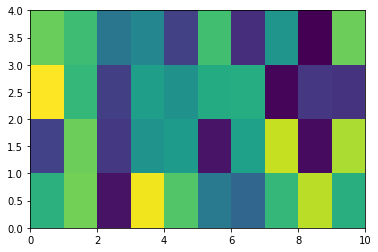

In [ ]:
plt.pcolormesh(lods)

In [ ]:
# make these smaller to increase the resolution
dx, dy = 1, 0.05

# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[slice(0, 0.5 + dy, dy),
                slice(0, 4 + dx, dx)]

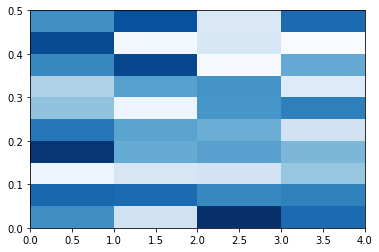

In [ ]:
plt.pcolormesh(x,y,lods.transpose(),cmap=brewer2mpl.get_map('Blues', 'Sequential', 9).mpl_colormap)

In [ ]:
file = '{}/heatmap/{}.lods'.format(env.outdir, basename(workdirs[0]))
chrID = re.search(r'\.chr([0-9XY]+)\.', file).group(1)
fig, ax = plt.subplots(1)
ax.set_title('Chromosome {}'.format(chrID))
plt.pcolormesh(fig,ax,lods.transpose(),
               xticklabels=[''] * len(lods),
               yticklabels=np.round(np.array(range(Num)) * theta_inc,2).tolist(),
               cmap=brewer2mpl.get_map('Blues', 'Sequential', 9).mpl_colormap)
fig.savefig('{}.png'.format(file))

IndexError: tuple index out of range

In [ ]:
heatmap('{}/heatmap/{}.lods'.format(env.outdir, basename(workdirs[0])), theta_inc, theta_max)
#heatmap('{}/heatmap/{}.hlods'.format(env.outdir, basename(workdir)), theta_inc, theta_max)

LOC102725121@1 1 11868 14362 0.5 0.0

DDX11L1 1 11873 14409 0.5 0.0

WASH7P 1 14361 29370 0.5 0.0

MIR6859-1@1,MIR6859-2@1,MIR6859-3@1,MIR6859-4@1 1 17368 17436 0.5 0.0

['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']


ValueError: cannot reshape array of size 1 into shape (10)

In [ ]:
workdirs

['./LINKAGE/LINKAGE/LINKAGE.chr1']